# Using PyMC3

PyMC3 is a Python package for doing MCMC using a variety of samplers, including Metropolis, Slice and Hamiltonian Monte Carlo. See [Probabilistic Programming in Python using PyMC](http://arxiv.org/abs/1507.08050) for a description. The GitHub [site](https://github.com/pymc-devs/pymc3) also has many examples and links for further exploration.

In [1]:
! pip install --quiet pymc3
! pip install --quiet daft
! pip install --quiet seaborn

In [2]:
! conda install --yes --quiet mkl-service

Fetching package metadata .........
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /opt/conda:
#
mkl-service               1.1.2                    py35_3  


**Other resources**

Some examples are adapted from:

- [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- [MCMC tutorial series](https://theclevermachine.wordpress.com/2012/11/19/a-gentle-introduction-to-markov-chain-monte-carlo-mcmc/)

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft

In [5]:
import theano
theano.config.warn.round=False

## Example: Estimating coin bias

We start with the simplest model - that of determining the bias of a coin from observed outcomes.

### Setting up the model    

In [6]:
n = 100
heads = 61

#### Analytical solution

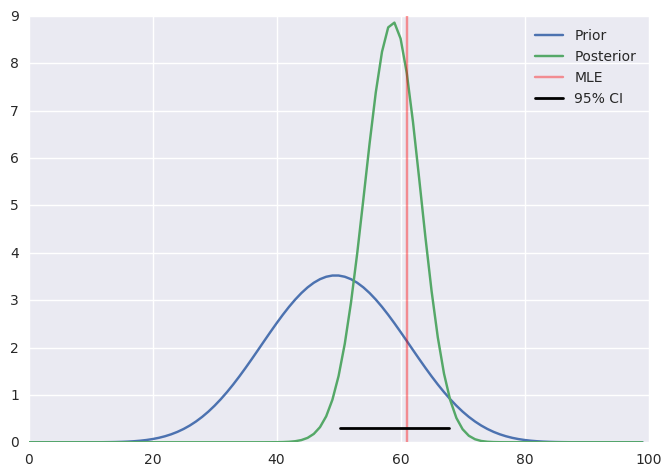

In [7]:
a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(heads+a, n-heads+b)
ci = post.interval(0.95)

xs = np.linspace(0, 1, 100)
plt.plot(prior.pdf(xs), label='Prior')
plt.plot(post.pdf(xs), label='Posterior')
plt.axvline(100*heads/n, c='red', alpha=0.4, label='MLE')
plt.xlim([0, 100])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.legend()
pass

#### Graphical model

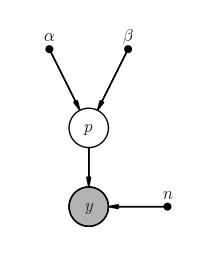

In [8]:
pgm = daft.PGM(shape=[2.5, 3.0], origin=[0, -0.5])

pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2, fixed=True))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2, fixed=True))
pgm.add_node(daft.Node("p", r"$p$", 1, 1))
pgm.add_node(daft.Node("n", r"$n$", 2, 0, fixed=True))
pgm.add_node(daft.Node("y", r"$y$", 1, 0, observed=True))

pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("n", "y")
pgm.add_edge("p", "y")

pgm.render()
pass

## Introduction to PyMC3

In [9]:
niter = 2000
with pm.Model() as coin_context:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.2744: 100%|██████████| 200000/200000 [00:15<00:00, 12698.15it/s]
Finished [100%]: Average ELBO = -4.2693
100%|██████████| 2000/2000 [00:01<00:00, 1753.85it/s]


### Specifying start,  sampler (step) and multiple chains

In [10]:
with coin_context:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(niter, step=step, start=start, njobs=4, random_seed=123)

Optimization terminated successfully.
         Current function value: 3.582379
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 2000/2000 [00:00<00:00, 5656.17it/s]


#### MAP estimate

In [11]:
start

{'p_logodds_': array(0.42956265615645184)}

### Summary of results

#### Discard 50% as burn-in

In [12]:
t = trace[niter//2:]
t['p'].shape

(4000,)

#### Getting values from the trace

In [13]:
p = trace.get_values('p', burn=niter//2, combine=True, chains=[0,2])
p.shape

(2000,)

#### Autocorrelation plot

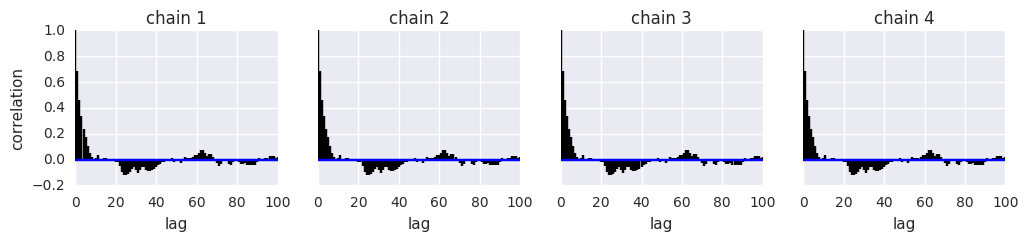

In [14]:
pm.autocorrplot(t, varnames=['p'])
pass

#### Calculate effective sample size

$$
\hat{n}_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}
$$

where $m$ is the number of chains, $n$ the number of steps per chain, $T$ the time when the autocorrelation first becomes negative, and $\hat{\rho}_t$ the autocorrelation at lag $t$.

In [15]:
pm.effective_n(t)

{'p': 767.0, 'p_logodds_': 765.0}

## Evaluate convergence

##### Gelman-Rubin

$$
\hat{R} = \frac{\hat{V}}{W}
$$

where $W$ is the within-chain variance and $\hat{V}$ is the posterior variance estimate for the pooled traces.  Values greater than one indicate that one or more chains have not yet converged.

Discrad burn-in steps for each chain. The idea is to see if the starting values of each chain come from the same distribution as the stationary state. 

- $W$ is the number of chains $m \times$ the variacne of each individual chain
- $B$ is the number of steps $n \times$ the variance of the chain means
- $\hat{V}$ is the weigthed average $(1 - \frac{1}{n})W + \frac{1}{n}B$

The idea is that $\hat{V}$ is an unbiased estimator of $W$ if the starting values of each chain come from the same distribution as the stationary state. Hence if $\hat{R}$ differs significantly from 1, there is probsbly no convergence and we need more iterations. This is done for each parameter $\theta$.

In [16]:
pm.gelman_rubin(t)

{'p': 0.99949987493746084, 'p_logodds_': 0.99949987493746095}

##### Geweke

Compares mean of initial with later segments of a trace for a parameter. Should have absolute value less than 1 at convergence.

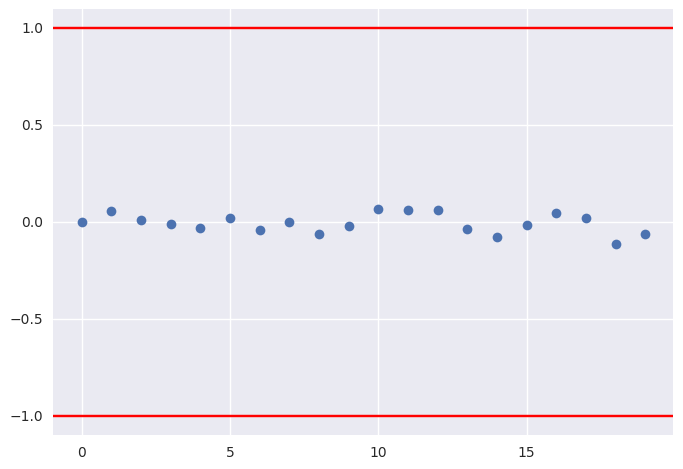

In [17]:
plt.plot(pm.geweke(t['p'])[:,1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)
pass

#### Textual summary

In [18]:
pm.summary(t, varnames=['p'])


p:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.615            0.050            0.002            [0.517, 0.698]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.517          0.581          0.616          0.654          0.698



#### Visual summary

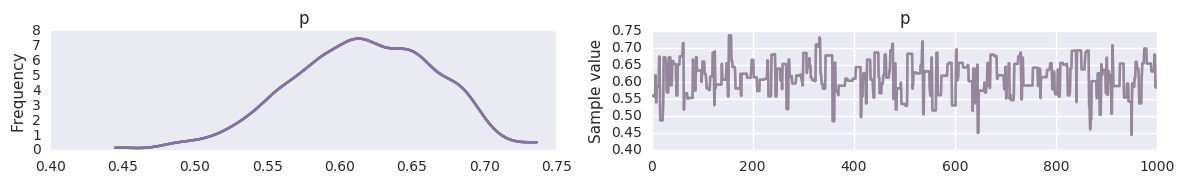

In [19]:
pm.traceplot(t, varnames=['p'])
pass

#### Posterior predictive samples

In [20]:
with coin_context:
    ppc = pm.sample_ppc(t, samples=100)
ppc['y'].ravel()

100%|██████████| 100/100 [00:00<00:00, 337.12it/s]


array([67, 70, 53, 66, 41, 56, 70, 60, 66, 46, 48, 63, 64, 58, 65, 55, 63,
       66, 67, 58, 70, 73, 69, 55, 51, 70, 58, 68, 59, 50, 60, 67, 59, 58,
       70, 56, 62, 63, 68, 65, 60, 64, 58, 44, 68, 75, 60, 55, 64, 66, 71,
       59, 62, 53, 62, 67, 65, 59, 56, 59, 62, 67, 61, 58, 79, 68, 54, 62,
       71, 60, 66, 57, 67, 70, 47, 58, 69, 68, 62, 67, 49, 61, 66, 40, 57,
       65, 53, 40, 67, 65, 55, 53, 70, 61, 57, 51, 66, 68, 68, 73])

## Saving traces

##### CSV

In [21]:
from pymc3.backends import Text

niter = 2000
with pm.Model() as text_save_demo:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    db = Text('trace')
    trace = pm.sample(niter, trace=db)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.2758: 100%|██████████| 200000/200000 [00:16<00:00, 12263.44it/s]
Finished [100%]: Average ELBO = -4.2726
100%|██████████| 2000/2000 [00:01<00:00, 1655.80it/s]


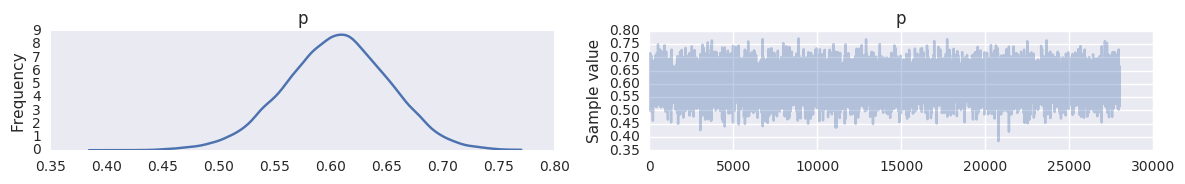

In [22]:
with text_save_demo:
    trace = pm.backends.text.load('trace')
    pm.traceplot(trace, varnames=['p'])

In [23]:
trace.varnames

['p_logodds_', 'p']

##### SQLite

If you are fitting a large complex model that may not fit in memory, you can use the SQLite3 backend to save the trace incremnetally to disk.

In [24]:
from pymc3.backends import SQLite

niter = 2000
with pm.Model() as sqlie3_save_demo:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    db = SQLite('trace.db')
    trace = pm.sample(niter, trace=db)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.2776: 100%|██████████| 200000/200000 [00:17<00:00, 11746.28it/s]
Finished [100%]: Average ELBO = -4.2749
100%|██████████| 2000/2000 [00:01<00:00, 1496.41it/s]


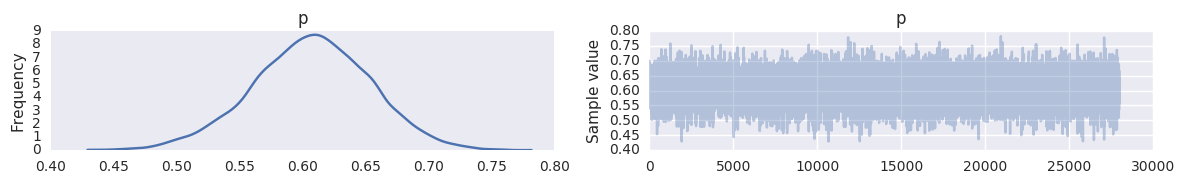

In [25]:
with sqlie3_save_demo:
    trace = pm.backends.sqlite.load('trace.db')
    pm.traceplot(trace, varnames=['p'])

## Sampling from prior

Just omit the `observed=` argument.

In [26]:
with pm.Model() as prior_context:
    sigma = pm.Gamma('sigma', alpha=2.0, beta=1.0)
    mu = pm.Normal('mu', mu=0, sd=sigma)
    trace = pm.sample(niter, step=pm.Metropolis())

100%|██████████| 2000/2000 [00:00<00:00, 4522.74it/s]


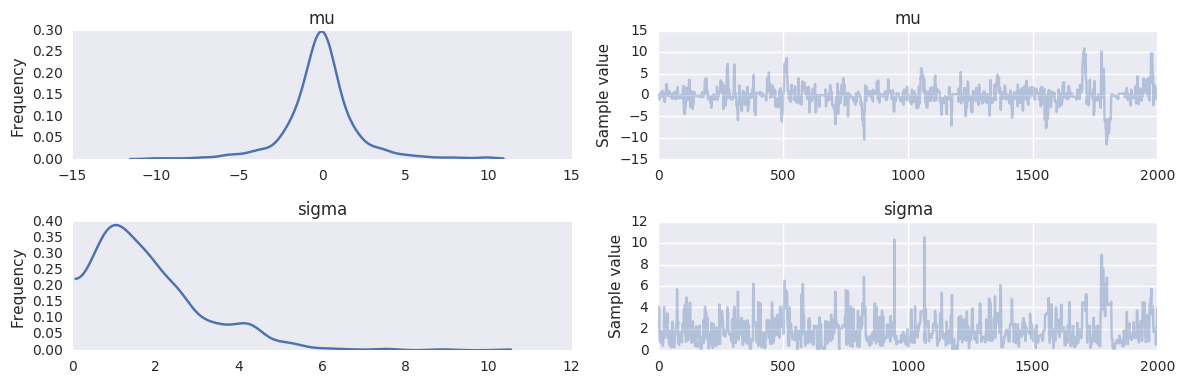

In [27]:
pm.traceplot(trace, varnames=['mu', 'sigma'])
pass

## Univariate normal distribution

In [28]:
xs = rng.normal(loc=5, scale=2, size=100)

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


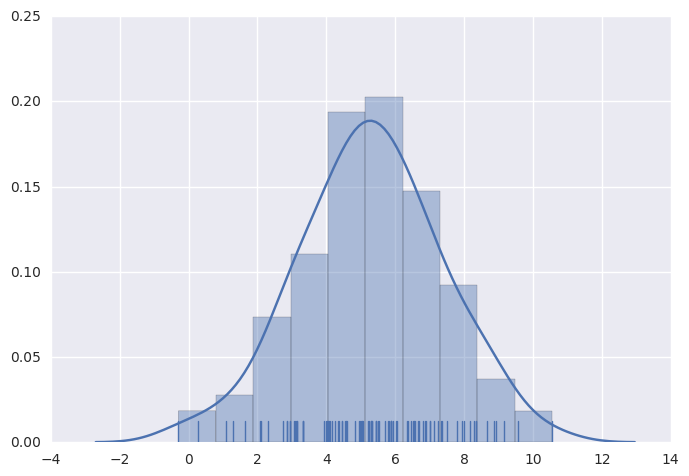

In [29]:
sns.distplot(xs, rug=True)
pass

## Sampling from posterior

In [30]:
niter = 2000
with pm.Model() as normal_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.Normal('y', mu=mu, sd=sd, observed=xs)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -223.18: 100%|██████████| 200000/200000 [00:19<00:00, 10185.34it/s]
Finished [100%]: Average ELBO = -223.18
100%|██████████| 2000/2000 [00:02<00:00, 847.15it/s] 


#### Find Highest Posterior Density (Credible intervals)

In [31]:
hpd = pm.stats.hpd(trace, alpha=0.05)
hpd

{'mu': array([ 4.87008876,  5.68313862]),
 'sd': array([ 1.80810522,  2.38210096]),
 'sd_log_': array([ 0.59227946,  0.86798286])}

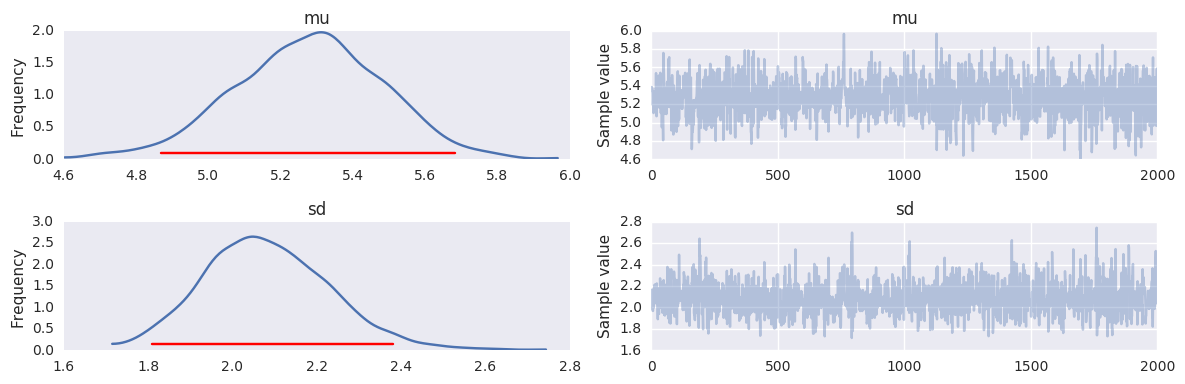

In [32]:
ax = pm.traceplot(trace, varnames=['mu', 'sd'],)

ymin, ymax = ax[0,0].get_ylim()
y = ymin + 0.05*(ymax-ymin)
ax[0, 0].plot(hpd['mu'], [y,y], c='red')

ymin, ymax = ax[1,0].get_ylim()
y = ymin + 0.05*(ymax-ymin)
ax[1, 0].plot(hpd['sd'], [y,y], c='red')
pass

## Evaluating goodness-of-fit

DIC, WAIC and BPIC are approximations to the out-of-sample error and can be used for model comparison. Likelihood is dependent on model complexity and should not be used for model comparisons.

In [33]:
post_mean = pm.df_summary(trace, varnames=trace.varnames)['mean'].to_dict()
post_mean

{'mu': 5.2774425669706622,
 'sd': 2.083811018098618,
 'sd_log_': 0.73163253719625909}

#### Likelihood

In [34]:
normal_context.logp(post_mean)

array(-220.7824869198777)

#### DIC

In [35]:
with normal_context:
    print(pm.stats.dic(trace))

445.508693887


#### WAIC

In [36]:
with normal_context:
    print(pm.stats.waic(trace))

(432.18295932008124, 14.386599474961665)


#### BPIC

In [37]:
with normal_context:
    print(pm.stats.bpic(trace))

447.480553911


-----